In [1]:
#不运行这个kernel在运行softmax时会自动restart（不知道为啥
%env MKL_THREADING_LAYER=SEQUENTIAL
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1


env: MKL_THREADING_LAYER=SEQUENTIAL
env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1


In [2]:
import numpy as np
from dataclasses import dataclass
from typing import List
import random
import scipy.optimize as opt
import scipy.linalg as sla


In [3]:
# 数据加载（复用作业给的风格）
@dataclass
class Dataset:
    Xtr: np.ndarray  # noisy train+val 的特征
    Str: np.ndarray  # noisy train+val 的标签（{0,1,2}）
    Xts: np.ndarray  # clean test 的特征
    Yts: np.ndarray  # clean test 的标签（{0,1,2}）

def load_npz(path): 
    d=np.load(path); 
    return Dataset(d['Xtr'],d['Str'],d['Xts'],d['Yts'])

#其他函数定义
def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)

def one_hot(y: np.ndarray, C: int) -> np.ndarray:
    oh = np.zeros((y.shape[0], C), dtype=np.float32)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

def softmax(z: np.ndarray) -> np.ndarray:
    z = z - z.max(axis=1, keepdims=True)       # 数值稳定
    expz = np.exp(z)
    return expz / (expz.sum(axis=1, keepdims=True) + 1e-12)

def accuracy(y_true, y_pred):
    return float((y_true == y_pred).mean())

def split(X, y, ratio=0.2, seed=42):
    set_seed(seed)
    n = X.shape[0]
    idx = np.random.permutation(n)
    sp = int(n * (1 - ratio))
    return X[idx[:sp]], y[idx[:sp]], X[idx[sp:]], y[idx[sp:]]

In [4]:
def standardize_train_val(Xtr, Xva):
    Xtr = Xtr.astype(np.float32)
    Xva = Xva.astype(np.float32)
    if Xtr.max() > 1.5:
        Xtr /= 255.0
        Xva /= 255.0
    mu = Xtr.mean(axis=0, keepdims=True)
    sg = Xtr.std(axis=0, keepdims=True) + 1e-6
    Xtr = (Xtr - mu) / sg
    Xva = (Xva - mu) / sg
    return Xtr, Xva

# 1 Warmup Model 初步分类器

## 1.1 Softmax

In [5]:
class SoftmaxWarmup:
    """简单多类 softmax 回归 (NumPy版)"""
    def __init__(self, in_dim: int, num_classes: int, lr: float = 0.05, weight_decay: float = 5e-4):
        self.C = num_classes
        self.W = 0.01 * np.random.randn(in_dim, num_classes).astype(np.float32)
        self.b = np.zeros((num_classes,), dtype=np.float32)
        self.lr = lr
        self.wd = weight_decay

    def _forward(self, X):
        logits = X @ self.W + self.b
        return softmax(logits)

    def _loss_and_grads(self, X, y):
        N = X.shape[0]
        P = self._forward(X)
        loss = -np.log(P[np.arange(N), y] + 1e-12).mean()
        if self.wd > 0:
            loss += 0.5 * self.wd * np.sum(self.W * self.W)
        G = P
        G[np.arange(N), y] -= 1.0
        G /= N
        dW = X.T @ G + self.wd * self.W
        db = G.sum(axis=0)
        return loss, dW, db

    def fit(self, X, y, Xval=None, yval=None, epochs=10, batch_size=256, verbose=True, seed=0):
        set_seed(seed)
        N = X.shape[0]
        for ep in range(1, epochs + 1):
            idx = np.random.permutation(N)
            Xs, ys = X[idx], y[idx]
            for st in range(0, N, batch_size):
                ed = min(st + batch_size, N)
                loss, dW, db = self._loss_and_grads(Xs[st:ed], ys[st:ed])
                self.W -= self.lr * dW
                self.b -= self.lr * db
            # 每个 epoch 打印一次训练和验证准确率
            if verbose:
                tr_acc = self.score(X, y)
                msg = f"[Softmax Warmup] epoch {ep:02d} | train_acc={tr_acc:.3f}"
                if Xval is not None:
                    va_acc = self.score(Xval, yval)
                    msg += f", val_acc={va_acc:.3f}"
                print(msg)

    def predict_proba(self, X):
        return self._forward(X)

    def predict(self, X):
        return np.argmax(self._forward(X), axis=1)

    def score(self, X, y):
        return accuracy(y, self.predict(X))

# 2 T估计器

## 2.1 选前百分之多少的样本作为锚点

In [7]:
def select_anchors_topk(probs: np.ndarray, top_pct: float = 0.01):
    N, C = probs.shape
    k = max(1, int(np.ceil(top_pct * N)))
    anchors = []
    for i in range(C):
        idx = np.argsort(probs[:, i])[-k:]  # 概率最高的 k 个
        anchors.append(idx)
    return anchors


## 2.2 估计 T 的每一行（两种常见法：概率平均 / 计数直方图）

In [8]:
def estimate_T_anchor(probs: np.ndarray,
                      noisy_labels: np.ndarray,
                      anchors: list,
                      use_counts: bool = False,
                      eps: float = 1e-6) -> np.ndarray:
    """
    用锚点估计转移矩阵 T。
    - 概率平均法（use_counts=False）：对锚点样本的概率向量取均值；
    - 计数法（use_counts=True）：对锚点样本的 noisy 标签计频率。
    """
    N, C = probs.shape
    T_hat = np.zeros((C, C), dtype=np.float32)
    for i in range(C):
        idx = anchors[i]
        if len(idx) == 0:
            row = np.zeros(C, dtype=np.float32); row[i] = 1.0
        else:
            if use_counts:
                hist = np.bincount(noisy_labels[idx], minlength=C).astype(np.float32)
                row = hist / (hist.sum() + eps)
            else:
                row = probs[idx].mean(axis=0).astype(np.float32)
                row = row / (row.sum() + eps)
        row = np.clip(row, eps, 1.0)
        row = row / row.sum()
        T_hat[i] = row
    return T_hat

def estimate_T_from_probs(probs: np.ndarray,
                          noisy_labels: np.ndarray,
                          top_pct: float = 0.01,
                          use_counts: bool = False,
                          verbose: bool = True):
    """
    入口：直接从 P= predict_proba(X) 开始估计 T。
    - probs: (N,C)  warm-up 输出的 softmax 概率（和 noisy_labels 一一对应）
    - noisy_labels: (N,)
    """
    assert probs.shape[0] == noisy_labels.shape[0], "probs 与 noisy_labels 数量必须一致。"
    C = probs.shape[1]

    # 1) 选锚点
    anchors = select_anchors_topk(probs, top_pct=top_pct)
    if verbose:
        cnts = [len(a) for a in anchors]
        print(f"[Anchor] top_pct={top_pct:.4f}, per-class counts={cnts}")

    # 2) 估计 T
    T_hat = estimate_T_anchor(probs, noisy_labels, anchors, use_counts=use_counts)

    # 3) 简单检查与打印
    if verbose:
        row_sums = T_hat.sum(axis=1)
        print("[T_hat] row sums:", np.round(row_sums, 6))
        # 按需：整数去掉小数点的友好打印
        def smart_round(x):
            s = f"{x:.4f}".rstrip('0').rstrip('.')
            return s if s != '' else '0'
        print("T_hat:\n",
              np.array2string(T_hat, formatter={'float_kind': smart_round}, separator=' '))

    return T_hat, anchors


# 3 看初步分类器在数据集上的准确率

In [9]:
data1 = load_npz("datasets/FashionMNIST0.3.npz")
data2 = load_npz("datasets/FashionMNIST0.6.npz")
data3 = load_npz("datasets/CIFAR.npz")

Xtr_1, ytr_1, Xva_1, yva_1 = split(data1.Xtr, data1.Str, ratio=0.2, seed=0)
Xtr_1_std, Xva_1_std = standardize_train_val(Xtr_1, Xva_1)

Xtr_2, ytr_2, Xva_2, yva_2 = split(data2.Xtr, data2.Str, ratio=0.2, seed=0)
Xtr_2_std, Xva_2_std = standardize_train_val(Xtr_2, Xva_2)

Xtr_3, ytr_3, Xva_3, yva_3 = split(data3.Xtr, data3.Str, ratio=0.2, seed=0)
#flatten
Xtr_3 = Xtr_3.reshape(len(Xtr_3), -1)
Xva_3 = Xva_3.reshape(len(Xva_3), -1)

Xtr_3_std, Xva_3_std = standardize_train_val(Xtr_3, Xva_3)

in_dim_1=Xtr_1_std.shape[1]
in_dim_2=Xtr_2_std.shape[1]
in_dim_3=Xtr_3_std.shape[1]

In [10]:
softmax_warm_1 = SoftmaxWarmup(in_dim_1, num_classes=3, lr=0.02, weight_decay=5e-4)
softmax_warm_1.fit(Xtr_1_std, ytr_1, Xva_1_std, yva_1,
                 epochs=10, batch_size=512, verbose=True, seed=0)

train_acc_1 = softmax_warm_1.score(Xtr_1_std, ytr_1)
val_acc_1 = softmax_warm_1.score(Xva_1_std, yva_1)
print()
print("FashionMNIST0.3:")
print(f"\nFinal train_acc: {train_acc_1:.4f}")
print(f"Final val_acc: {val_acc_1:.4f}")

[Softmax Warmup] epoch 01 | train_acc=0.663, val_acc=0.667
[Softmax Warmup] epoch 02 | train_acc=0.669, val_acc=0.678
[Softmax Warmup] epoch 03 | train_acc=0.613, val_acc=0.609
[Softmax Warmup] epoch 04 | train_acc=0.665, val_acc=0.667
[Softmax Warmup] epoch 05 | train_acc=0.667, val_acc=0.674
[Softmax Warmup] epoch 06 | train_acc=0.675, val_acc=0.681
[Softmax Warmup] epoch 07 | train_acc=0.676, val_acc=0.686
[Softmax Warmup] epoch 08 | train_acc=0.640, val_acc=0.636
[Softmax Warmup] epoch 09 | train_acc=0.669, val_acc=0.673
[Softmax Warmup] epoch 10 | train_acc=0.674, val_acc=0.672

FashionMNIST0.3:

Final train_acc: 0.6736
Final val_acc: 0.6717


In [11]:
softmax_warm_2 = SoftmaxWarmup(in_dim_2, num_classes=3, lr=0.02, weight_decay=5e-4)
softmax_warm_2.fit(Xtr_2_std, ytr_2, Xva_2_std, yva_2,
                 epochs=10, batch_size=512, verbose=True, seed=0)

train_acc_2 = softmax_warm_2.score(Xtr_2_std, ytr_2)
val_acc_2 = softmax_warm_2.score(Xva_2_std, yva_2)
print()
print("FashionMNIST0.6:")
print(f"\nFinal train_acc: {train_acc_2:.4f}")
print(f"Final val_acc: {val_acc_2:.4f}")

[Softmax Warmup] epoch 01 | train_acc=0.377, val_acc=0.356
[Softmax Warmup] epoch 02 | train_acc=0.338, val_acc=0.340
[Softmax Warmup] epoch 03 | train_acc=0.347, val_acc=0.321
[Softmax Warmup] epoch 04 | train_acc=0.381, val_acc=0.363
[Softmax Warmup] epoch 05 | train_acc=0.384, val_acc=0.351
[Softmax Warmup] epoch 06 | train_acc=0.390, val_acc=0.353
[Softmax Warmup] epoch 07 | train_acc=0.372, val_acc=0.337
[Softmax Warmup] epoch 08 | train_acc=0.391, val_acc=0.367
[Softmax Warmup] epoch 09 | train_acc=0.352, val_acc=0.344
[Softmax Warmup] epoch 10 | train_acc=0.366, val_acc=0.336

FashionMNIST0.6:

Final train_acc: 0.3661
Final val_acc: 0.3358


In [12]:
softmax_warm_3 = SoftmaxWarmup(in_dim_3, num_classes=3, lr=0.02, weight_decay=5e-4)
softmax_warm_3.fit(Xtr_3_std, ytr_3, Xva_3_std, yva_3,
                 epochs=10, batch_size=512, verbose=True, seed=0)

train_acc_3 = softmax_warm_3.score(Xtr_3_std, ytr_3)
val_acc_3 = softmax_warm_3.score(Xva_3_std, yva_3)
print()
print("CIFAR:")
print(f"\nFinal train_acc: {train_acc_3:.4f}")
print(f"Final val_acc: {val_acc_3:.4f}")

[Softmax Warmup] epoch 01 | train_acc=0.350, val_acc=0.332
[Softmax Warmup] epoch 02 | train_acc=0.351, val_acc=0.335
[Softmax Warmup] epoch 03 | train_acc=0.358, val_acc=0.341
[Softmax Warmup] epoch 04 | train_acc=0.364, val_acc=0.340
[Softmax Warmup] epoch 05 | train_acc=0.368, val_acc=0.347
[Softmax Warmup] epoch 06 | train_acc=0.366, val_acc=0.346
[Softmax Warmup] epoch 07 | train_acc=0.366, val_acc=0.347
[Softmax Warmup] epoch 08 | train_acc=0.371, val_acc=0.342
[Softmax Warmup] epoch 09 | train_acc=0.365, val_acc=0.337
[Softmax Warmup] epoch 10 | train_acc=0.367, val_acc=0.335

CIFAR:

Final train_acc: 0.3675
Final val_acc: 0.3347


# 4 估计前2个数据集的T，比对

In [14]:
import numpy as np

def evaluate_T(T_hat: np.ndarray, T_true: np.ndarray, verbose: bool = True):
    
    assert T_hat.shape == T_true.shape, "T_hat.shape != T_true"
    diff = T_hat - T_true

    # (1) 每行 L1 差
    per_row_L1 = np.sum(np.abs(diff), axis=1)

    # (2) Frobenius 范数
    frob = np.linalg.norm(diff, 'fro')

    # (3) 最大绝对误差
    max_abs = np.max(np.abs(diff))

    if verbose:
        print("T_hat:\n", np.round(T_hat, 4))
        print("T_true:\n", np.round(T_true, 4))
        print("-" * 30)
        print("per row L1:", np.round(per_row_L1, 4))
        print("Frobenius:", round(float(frob), 4))
        print("max|Δ|:", round(float(max_abs), 4))

    return {
        "per_row_L1": per_row_L1,
        "frobenius": frob,
        "max_abs": max_abs
    }


In [15]:
import numpy as np

# ==== 先把两套真 T 写成常量（来自作业说明） ====
T_true_03 = np.array([[0.7, 0.3, 0.0],
                      [0.0, 0.7, 0.3],
                      [0.3, 0.0, 0.7]], dtype=np.float32)

T_true_06 = np.array([[0.4, 0.3, 0.3],
                      [0.3, 0.4, 0.3],
                      [0.3, 0.3, 0.4]], dtype=np.float32)



In [20]:
# print("!!(  FashionMNIST0.3  )!!\n")
# P_1 = softmax_warm_1.predict_proba(Xtr_1_std)  # (N, C)

# for a in [0.05, 0.1, 0.2, 0.22, 0.25, 0.28, 0.3]:
#     T_hat_1, _ = estimate_T_from_probs(P_1, ytr_1, top_pct=a, use_counts=True, verbose=False)
#     print(f"---------Softmax+Counts α={a}--------------- ")
#     #print(f"Softmax+Counts α={a}: \n", np.round(T_hat,4))
#     evaluate_T(T_hat_1, T_true_03)
#     print()


α=0.05 | Frobenius=0.1405 | max|Δ|=0.0847
α=0.10 | Frobenius=0.1031 | max|Δ|=0.0729
α=0.20 | Frobenius=0.0775 | max|Δ|=0.0517
α=0.22 | Frobenius=0.0709 | max|Δ|=0.0497
α=0.25 | Frobenius=0.0650 | max|Δ|=0.0439
α=0.28 | Frobenius=0.0679 | max|Δ|=0.0444
α=0.30 | Frobenius=0.0806 | max|Δ|=0.0498


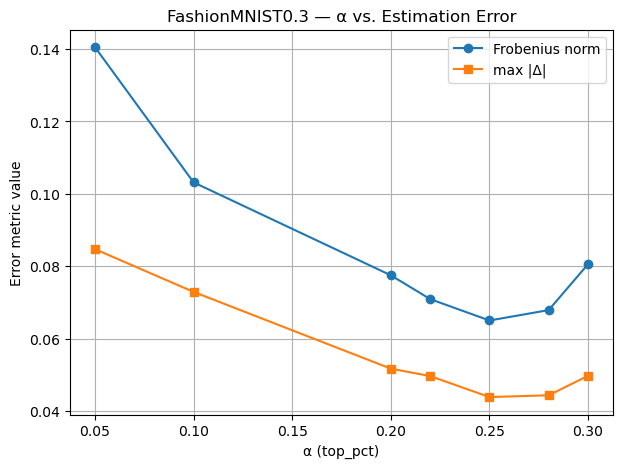

In [19]:
import matplotlib.pyplot as plt

alphas = [0.05, 0.1, 0.2, 0.22, 0.25, 0.28, 0.3]
frob_list, maxabs_list = [], []

P_1 = softmax_warm_1.predict_proba(Xtr_1_std)

for a in alphas:
    T_hat_1, _ = estimate_T_from_probs(P_1, ytr_1, top_pct=a, use_counts=True, verbose=False)
    diff = T_hat_1 - T_true_03
    frob = np.linalg.norm(diff, 'fro')
    max_abs = np.max(np.abs(diff))
    frob_list.append(frob)
    maxabs_list.append(max_abs)
    print(f"α={a:.2f} | Frobenius={frob:.4f} | max|Δ|={max_abs:.4f}")

# ---------- 可视化 ----------
plt.figure(figsize=(7, 5))
plt.plot(alphas, frob_list, marker='o', label='Frobenius norm')
plt.plot(alphas, maxabs_list, marker='s', label='max |Δ|')
plt.xlabel("α (top_pct)")
plt.ylabel("Error metric value")
plt.title("FashionMNIST0.3 — α vs. Estimation Error")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# print("!!(  FashionMNIST0.6  )!!\n")
# P_2 = softmax_warm_2.predict_proba(Xtr_2_std)  # (N, C)

# for a in [0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3]:
#     T_hat_2, _ = estimate_T_from_probs(P_2, ytr_2, top_pct=a, use_counts=True, verbose=False)
#     print(f"---------Softmax+Counts α={a}--------------- ")
#     #print(f"Softmax+Counts α={a}: \n", np.round(T_hat,4))
#     evaluate_T(T_hat_2, T_true_06)
#     print()

α=0.05 | Frobenius=0.1347 | max|Δ|=0.0819
α=0.08 | Frobenius=0.1107 | max|Δ|=0.0628
α=0.10 | Frobenius=0.0984 | max|Δ|=0.0653
α=0.12 | Frobenius=0.0937 | max|Δ|=0.0640
α=0.15 | Frobenius=0.0921 | max|Δ|=0.0704
α=0.20 | Frobenius=0.1002 | max|Δ|=0.0760
α=0.22 | Frobenius=0.0945 | max|Δ|=0.0709
α=0.25 | Frobenius=0.0916 | max|Δ|=0.0686
α=0.28 | Frobenius=0.0994 | max|Δ|=0.0724
α=0.30 | Frobenius=0.0985 | max|Δ|=0.0704


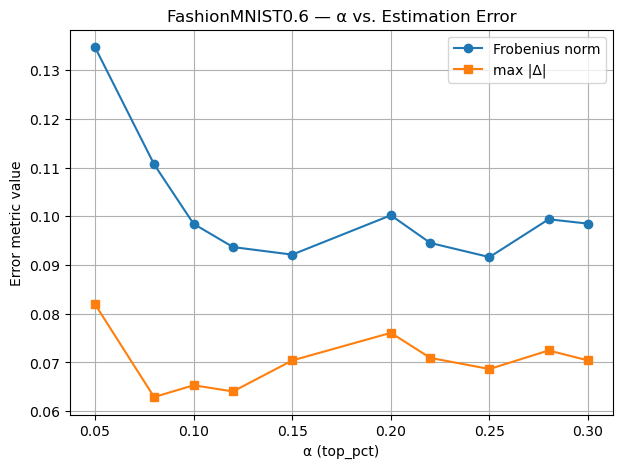

In [26]:
alphas = [0.05, 0.08, 0.1, 0.12, 0.15, 0.2,0.22, 0.25, 0.28, 0.3]
frob_list, maxabs_list = [], []

P_2 = softmax_warm_2.predict_proba(Xtr_2_std)

for a in alphas:
    T_hat_2, _ = estimate_T_from_probs(P_2, ytr_2, top_pct=a, use_counts=True, verbose=False)
    diff = T_hat_2 - T_true_06
    frob = np.linalg.norm(diff, 'fro')
    max_abs = np.max(np.abs(diff))
    frob_list.append(frob)
    maxabs_list.append(max_abs)
    print(f"α={a:.2f} | Frobenius={frob:.4f} | max|Δ|={max_abs:.4f}")

# ---------- 可视化 ----------
plt.figure(figsize=(7, 5))
plt.plot(alphas, frob_list, marker='o', label='Frobenius norm')
plt.plot(alphas, maxabs_list, marker='s', label='max |Δ|')
plt.xlabel("α (top_pct)")
plt.ylabel("Error metric value")
plt.title("FashionMNIST0.6 — α vs. Estimation Error")
plt.legend()
plt.grid(True)
plt.show()

# 5 估计CIFAR的T

In [25]:
print("!!(  CIFAR  )!!\n")
P_3 = softmax_warm_3.predict_proba(Xtr_3_std)  # (N, C)
# for a in []:
#     T_hat_3, _ = estimate_T_from_probs(P_3, ytr_3, top_pct=a, use_counts=True, verbose=False)
#     #print(f"---------Softmax+Counts α={a}--------------- ")
#     print(f"Softmax+Counts α={a}: \n", np.round(T_hat_3,4))
#     #evaluate_T(T_hat_2, T_true_06)
#     print()
T_hat_3, _ = estimate_T_from_probs(P_3, ytr_3, top_pct=0.25, use_counts=True, verbose=False)
print(f"Softmax+Counts α=0.25: \n", np.round(T_hat_3,4))

!!(  CIFAR  )!!

Softmax+Counts α=0.25: 
 [[0.3983 0.332  0.2697]
 [0.2967 0.3587 0.3447]
 [0.31   0.3097 0.3803]]
